# Filtros Convolucionais

Retomando o que já aprendemos
* **Kernels** são filtros convolucionais. Na prática são arrays n-dimensionais que são operados com o dado através da convolução.
* Os **pesos do kernel**, ou seja, os elementos do array, carregam o padrão que será procurado no dado original.

Esses filtros podem ser manualmente projetados se já sabemos o padrão que queremos procurar, ou o mapa de ativação desejado. A seguir vamos conhecer alguns kernels convolucionais e a intuição por trás do padrão que eles projetam.

In [24]:
import matplotlib.pyplot as plt
from skimage import io

from scipy.signal import convolve
import numpy as np

import requests
import dropbox as dbx

Na célula a seguir temos novamente a função utilizada na impressão dos resultados.

In [2]:
def show(img, kernel, resultado, titulo):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  plot = [img, kernel, resultado]
  titulos = ['Imagem', titulo, 'Mapa de Ativação']
  for k, ax in enumerate(axs):
    ax.imshow(plot[k], cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(titulos[k])

  for i, line in enumerate(kernel):
    for j, col in enumerate(line):
      axs[1].text(j, i, '{:.2f}'.format(col), fontsize=12, color='red', ha='center', va='center')

Como dado de entrada usaremos a imagem de um dos instrutores da Alura, o Guilherme Silveira.

In [11]:
url = 'https://s3.us-east-1.amazonaws.com/jarvis-caelum/GUI.jpg'
r = requests.get(url)
with open('dados/GUI.jpg', 'wb') as f:
    f.write(r.content)

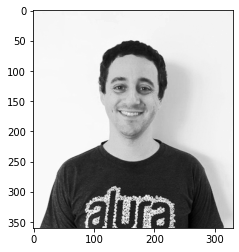

In [13]:
img = io.imread('dados/GUI.jpg')
# Para ler apenas um canal de cor da imagem
img = img[:,:,0]
plt.imshow(img, cmap='gray')

## Filtro da Média

Ao aplicar este filtro a uma imagem, o mapa de ativação resultante será uma versão suavizada da imagem original (mais "borrada", menos nítida). Este efeito é alcançado explorando a operação de convolução para **tirar a média dos pixels** de subregiões da imagem.

Os pesos desse kernel são definidos para replicar a operação da média, ou seja, para um filtro $3 \times 3$ com 9 pesos, temos que: <br><br>
\begin{equation}
\frac{\sum_{x=1}^{9} p(x)}{9} = \sum_{x=1}^{9} \frac{1}{9} p(x)
\end{equation}

Vamos modelar dois filtros:
* $3 \times 3$, com todos os pesos iguais a $\frac{1}{3^2}$ 

* $9 \times 9$, com todos os pesos iguais a $\frac{1}{9^2}$

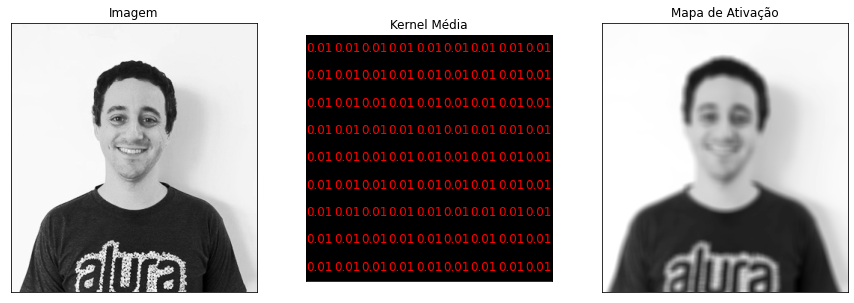

In [15]:
##### MEAN
# reference https://homepages.inf.ed.ac.uk/rbf/HIPR2/mean.htm
kernel_media = np.zeros((9,9))
kernel_media[:] = 1.0/(9**2)

resultado = convolve(img, kernel_media, mode='valid')
show(img, kernel_media, resultado, 'Kernel Média')

## Sobel 

Esse se parece muito com o filtro de bordas que já fizemos na aula passada, com a diferença que os vizinhos diretos do pixel central tem valor absoluto de maior intensidade (na horizontal ou na vertical, a depender da borda desejada).

> Após realizar a convolução, podemos imprimir os **valores absolutos** do mapa de ativação para visualizar as bordas independente do sinal da ativação.


[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]


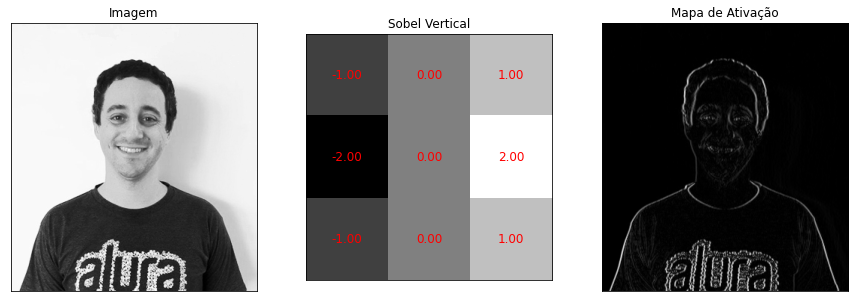

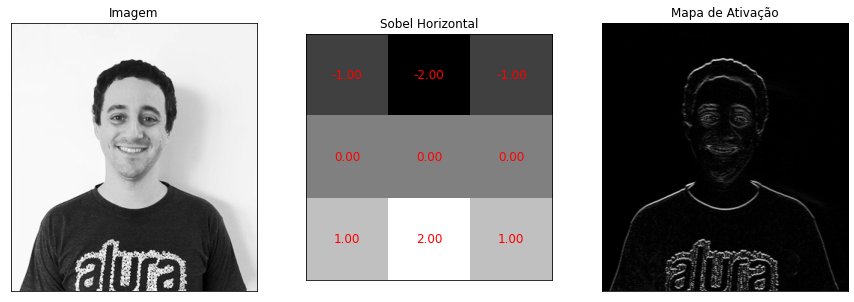

In [16]:
# reference: https://pt.wikipedia.org/wiki/Filtro_Sobel

##### SOBEL VERTICAL
sobel_v = np.zeros((3,3))
sobel_v[:, 0] = -1
sobel_v[:, 2] = 1
sobel_v[1, [0, 2]] = [-2, 2]
# print(sobel_v)

resultado = convolve(img, sobel_v, mode='valid')
show(img, sobel_v, np.abs(resultado), 'Sobel Vertical')


##### SOBEL HORIZONTAL
sobel_h = np.zeros((3,3))
sobel_h[0, :] = -1
sobel_h[2, :] = 1
sobel_h[[0, 2], 1] = [-2, 2]
print(sobel_h)

resultado = convolve(img, sobel_h, mode='valid')
show(img, sobel_h, np.abs(resultado), 'Sobel Horizontal')


## Laplace

Por fim, vamos ver mais um filtro utilizado para detecção de bordas, o Laplace. Diferente do Sobel, este filtro destaca igualmente bordas de diferentes direções.

[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]


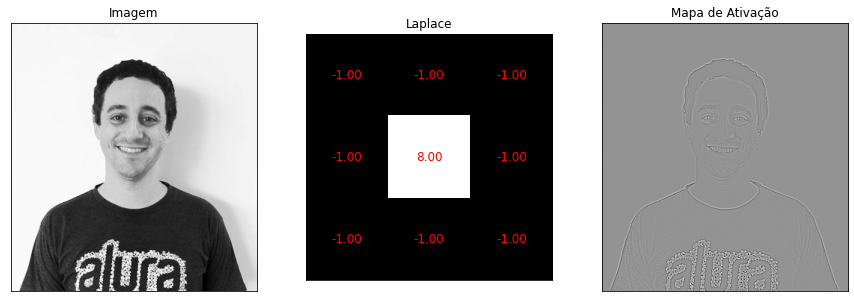

In [21]:
##### LAPLACE
#reference: https://en.wikipedia.org/wiki/Discrete_Laplace_operator | https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm

laplace = np.ones((3,3)) * -1
laplace[1,1] = 8
print(laplace)

resultado = convolve(img, laplace, mode='valid')
show(img, laplace, --resultado, 'Laplace')

# Convolução e Padrões Complexos

Para entender melhor como a convolução funciona como um casamento de padrões, vamos agora definir um filtro convolucional mais complexo, mas capaz de encontrar um casamento perfeito no dado.

Primeiro vamos baixar a imagem que será usada de exemplo:

In [28]:
# url =  'https://www.dropbox.com/s/0nrix9eknyybuqk/image_2007_000032.jpg?dl=0'


Vamos separar um próprio patch da imagem para usar como filtro de convolução. Para facilitar a visualização, selecionamos a região da turbina, localizada nas coordenadas ```[109, 129, 255, 275]```

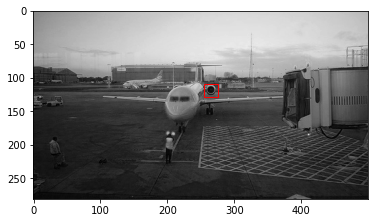

In [29]:
import matplotlib.patches as patches

# Imprime imagem e seleciona retangulo
img = io.imread('dados/plane.jpg')
img = img[:,:,0]
retangulo = [109, 129, 255, 275]


# # Imprime imagem e retangulo
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.add_patch(patches.Rectangle((retangulo[2], retangulo[0]),
                               (retangulo[3] - retangulo[2]),
                               (retangulo[1] - retangulo[0]), color='red', fill=False))

Para que o patch possa ser utilizado como filtro de convolução, precisamos:
* Subtrair o patch pelo valor do pixel médio (centralizando a distribuição)
* Inverter o filtro com a função ```flip``` do numpy. 

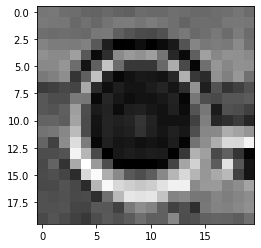

In [30]:
patch = img[retangulo[0]:retangulo[1], retangulo[2]:retangulo[3]]
patch = patch - patch.mean()
patch = np.flip(patch)

plt.imshow(patch, cmap='gray')

Vamos ver agora o resultado da convolução.

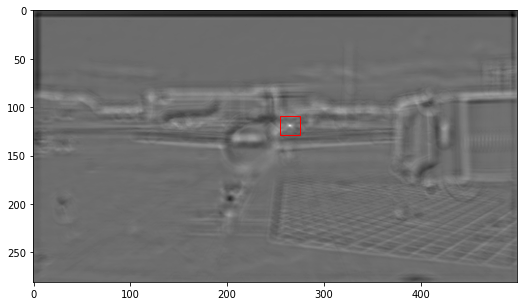

In [33]:
resultado = convolve(img, patch, mode='same')

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(resultado, cmap='gray')
ax.add_patch(patches.Rectangle((retangulo[2], retangulo[0]),
                               (retangulo[3] - retangulo[2]),
                               (retangulo[1] - retangulo[0]), color='red', fill=False))